# Spatial maps of WoFS fields

By: Ty Janoski

In this notebook, we will focus on making spatial maps of relevant fields from
WoFS. Other types of plots will be elsewhere.


## Import statements

In [1]:
# Imports
import xarray as xr
import dask
import numpy as np
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables
from matplotlib.animation import FuncAnimation

# Configurations
plt.style.use("dark_background")
dask.config.set({"array.slicing.split_large_chunks": False})

## Read in data

In [2]:
def load_data(init: str, keyword: str) -> xr.Dataset:

    # Note that this function depends on a consistent file structure so if you
    # change that, you'll need to change this function.
    # First, determine starting date
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
        use_cftime=True,
    )

    # read in data
    data = xr.open_mfdataset(
        "/mnt/drive2/wof-runs/post-processed/"
        + init
        + "/wofs_"
        + keyword.upper()
        + "*.nc",
        concat_dim="time",
        combine="nested",
        parallel=True,
    )
    data["time"] = new_dates
    return data

In [3]:
ens = [load_data(i, "ens") for i in ["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"]]
ens = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in ens]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"], dims="init")
init = init.assign_coords({"init": init})

# concat
ens = xr.concat(ens, dim=init).chunk({"init": 1, "time": -1})

## Other functions

In [4]:
def process_dim(da):
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")

def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)

## Data Pre-processing

In [5]:
# grab UH and rain
rain = ens.rain.stack(run=("init", "ne"))
uh = ens.uh_0to2.stack(run=("init", "ne"))
comp_dz = ens.comp_dz.stack(run=("init", "ne"))

### Plotting attributes

In [6]:
# Isolate 2-dimensional lat and lon
lat = ens.xlat.isel(time=0, init=0).squeeze()
lon = ens.xlon.isel(time=0, init=0).squeeze()

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=ens.attrs["CEN_LON"],
    central_latitude=ens.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # this is the projection that WoFS uses

# Get MetPy precipitation colortable
precip_cmap = ctables.registry.get_colortable("precipitation")
dbz_cmap = ctables.registry.get_colortable("NWSReflectivity")

## PMM, Ensemble Mean, and Probability of Exceedence

### Rain

#### Calculations

In [15]:
# Calculate 01 - 02 UTC total rainfall accumulation
with ProgressBar():
    rain_0102 = (
        rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
        .sum(dim="time")
        .compute()
    )  # mm

# Calculate PMM
pmm_rain = pmm(rain_0102)

# Ensemble and initialization mean
ens_mean_rain = rain_0102.mean(dim="run")

# Probability of exceedence
# 15 km neighborhood
poe_rain = (rain_0102 > 1).sum(dim="run").rolling(
    lat=5, lon=5, center=True
).max() / len(rain_0102.run)

[                                        ] | 0% Completed | 118.54 ms

[########################################] | 100% Completed | 29.77 s


#### Plot comparing quantities

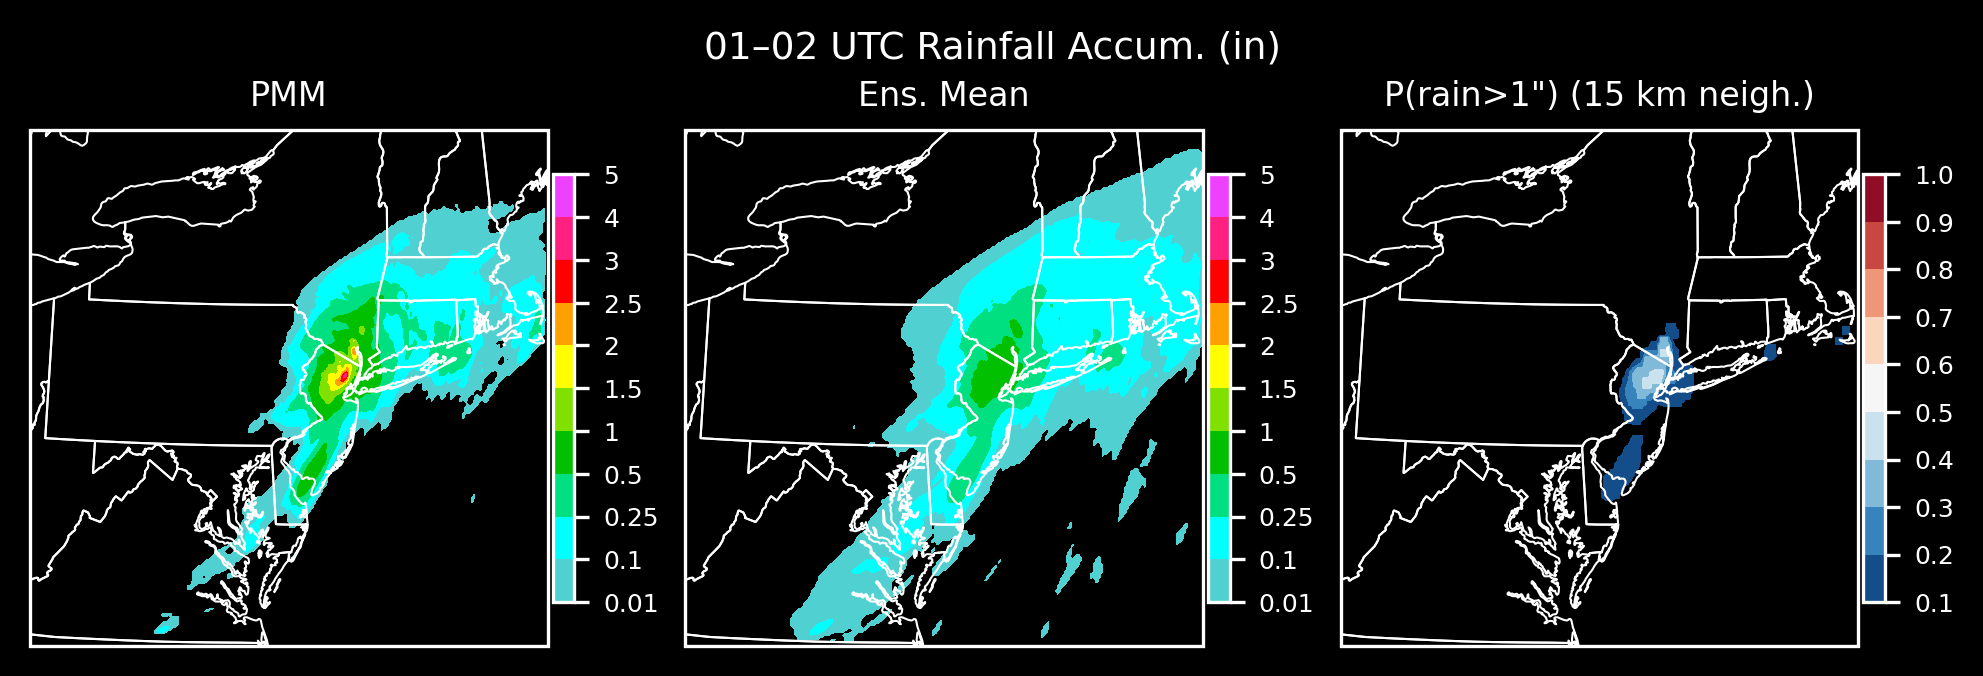

In [16]:
# Make list of titles
titles = ["PMM", "Ens. Mean", 'P(rain>1") (15 km neigh.)']

# Values to plot
values = [pmm_rain, ens_mean_rain, poe_rain]

# Create 1x3 figure
fig, axs = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.17),
    sharex=True,
    sharey=True,
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axs):  # loop through each axis
    # Make plot
    if i < 2:  # if not the last plot
        p = ax.contourf(
            lon,
            lat,
            values[i].where(values[i] > 0.01),
            colors=precip_cmap.colors[1:12],
            levels=[0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5],
            transform=ccrs.PlateCarree(),
        )
    else:  # if the last plot
        p = ax.contourf(
            lon,
            lat,
            values[i],
            cmap="RdBu_r",
            levels=np.arange(0.1, 1.1, 0.1),  # levels from 0.1 to 1 by 0.1
            transform=ccrs.PlateCarree(),
        )
    # Add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Add title
    ax.set_title(titles[i], fontsize=8)

    # Add colorbar to each plot
    cb = fig.colorbar(p, ax=ax, shrink=0.8, pad=0.01)
    cb.ax.tick_params(labelsize=6)

    # If in first two plots, set colorbar labels to match levels
    if i < 2:
        cb.set_ticks([0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5])  # set ticks
        cb.set_ticklabels(
            [0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5]
        )  # set tick labels

# Make suptitle
fig.suptitle("01–02 UTC Rainfall Accum. (in)", fontsize=9)

plt.show()
# plt.savefig("test.pdf",bbox_inches="tight")

### Composite Reflectivity

#### Calculations

In [9]:
# Select 01–02 UTC composite reflectivity
with ProgressBar():
    comp_dz_0102 = comp_dz.sel(
        time=slice("2021-09-02 01:00:00", "2021-09-02 02:00:00")
    ).compute()

# Calculate PMM
pmm_comp_dz = pmm(comp_dz_0102)

# Ensemble and initialization mean
ens_mean_comp_dz = comp_dz_0102.mean(dim="run")

# Probability of exceedence
# 15 km neighborhood
poe_comp_dz = (comp_dz_0102 > 40).sum(dim="run").rolling(
    lat=5, lon=5, center=True
).max() / len(comp_dz_0102.run)

[                                        ] | 0% Completed | 212.59 ms

[########################################] | 100% Completed | 27.13 s


#### Plots

MovieWriter Pillow unavailable; using Pillow instead.


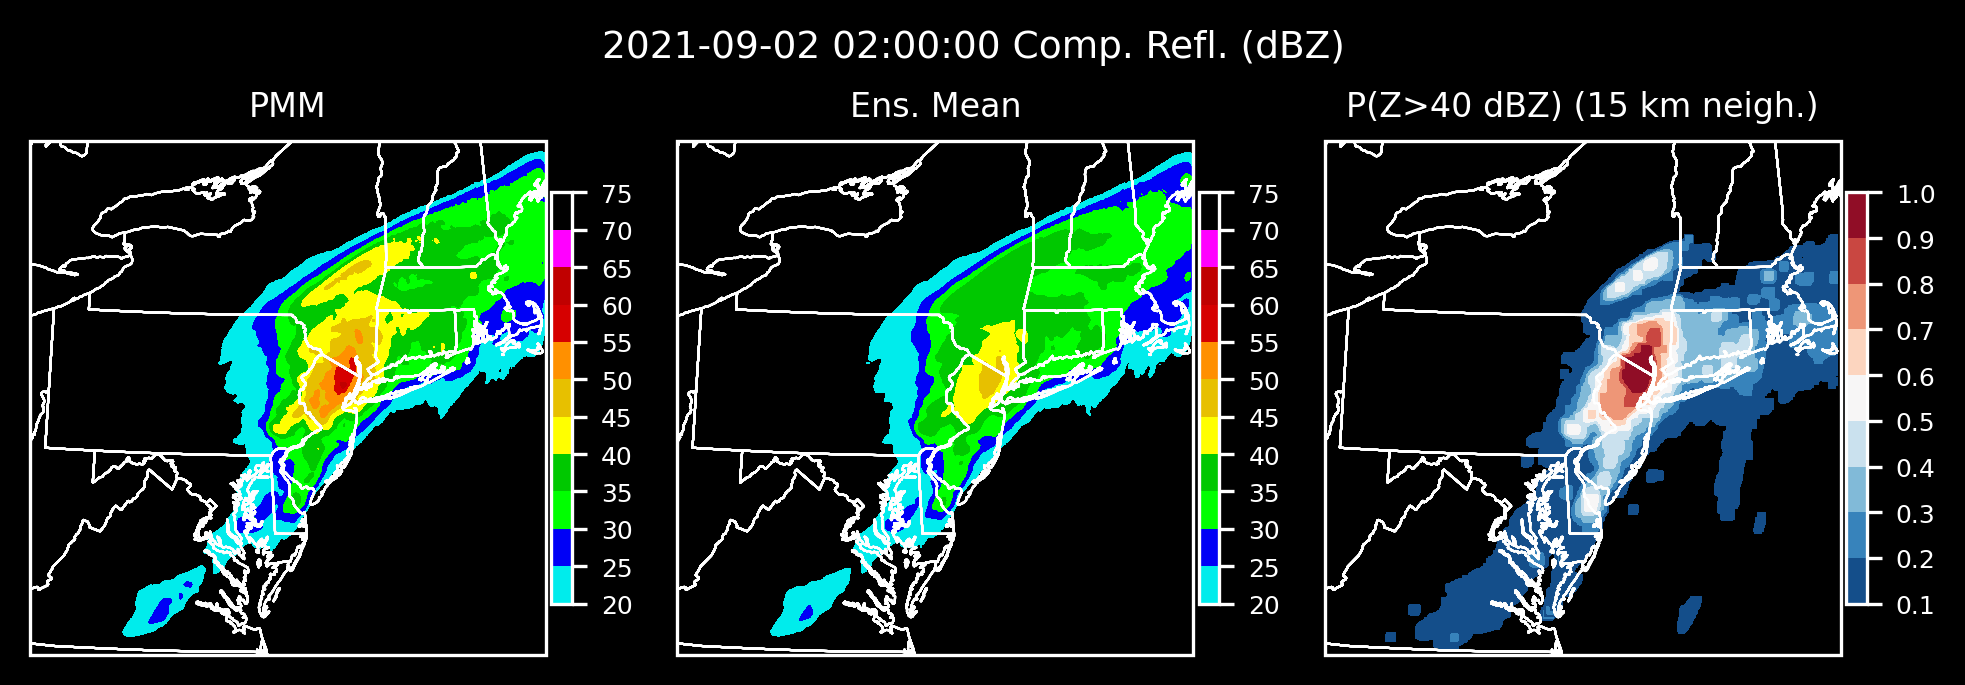

In [10]:
# We want to make an animated gif of the pmm, ensemble mean, and poe
# Make list of titles
titles = ["PMM", "Ens. Mean", 'P(Z>40 dBZ) (15 km neigh.)']

# Values to plot
values = [pmm_comp_dz, ens_mean_comp_dz, poe_comp_dz]

# Create 1x3 figure
fig, axs = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.17),
    sharex=True,
    sharey=True,
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj)
)
def update(frame):
    for i, ax in enumerate(axs):  # loop through each axis
        # Make plot
        if i < 2:  # if not the last plot
            p = ax.contourf(
                lon,
                lat,
                values[i].isel(time=frame),
                cmap=dbz_cmap,
                levels=range(20, 80, 5),
                transform=ccrs.PlateCarree(),
            )
        else:  # if the last plot
            p = ax.contourf(
                lon,
                lat,
                values[i].isel(time=frame),
                cmap="RdBu_r",
                levels=np.arange(0.1, 1.1, 0.1),  # levels from 0.1 to 1 by 0.1
                transform=ccrs.PlateCarree(),
            )
        # Add state boundaries
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

        # Add title
        ax.set_title(titles[i], fontsize=8)

        # Remove previous colorbar if exists
        if hasattr(ax, 'colorbar'):
            ax.colorbar.remove()

        # Add colorbar to each plot
        cb = fig.colorbar(p, ax=ax, shrink=0.8, pad=0.01)
        cb.ax.tick_params(labelsize=6)
        ax.colorbar = cb

        # If in first two plots, set colorbar labels to match levels
        if i < 2:
            cb.set_ticks(range(20, 80, 5))  # set ticks
            cb.set_ticklabels(range(20, 80, 5))  # set tick labels

    # Make suptitle containing time value and stating reflectivity
    fig.suptitle(
        str(comp_dz_0102.time.isel(time=frame).values) + " Comp. Refl. (dBZ)",
        fontsize=9,
    )

anim = FuncAnimation(fig, update, frames=13, repeat=True)

anim.save("comp_refl.gif",writer="Pillow",fps=2)
plt.show()

### Updraft Helicity (and rain)

#### Calculations

In [11]:
# Select 01–02 UTC composite reflectivity
with ProgressBar():
    uh_0102 = uh.sel(
        time=slice("2021-09-02 01:00:00", "2021-09-02 02:00:00")
    ).compute()

# Calculate PMM
pmm_uh = pmm(uh_0102)

# Ensemble and initialization mean
ens_mean_uh = uh_0102.mean(dim="run")

# Probability of exceedence
# 15 km neighborhood
poe_uh = (uh_0102 > 20).sum(dim="run").rolling(
    lat=5, lon=5, center=True
).max() / len(uh_0102.run)

[###                                     ] | 7% Completed | 1.29 s ms

[########################################] | 100% Completed | 26.37 s


#### Plots

MovieWriter Pillow unavailable; using Pillow instead.


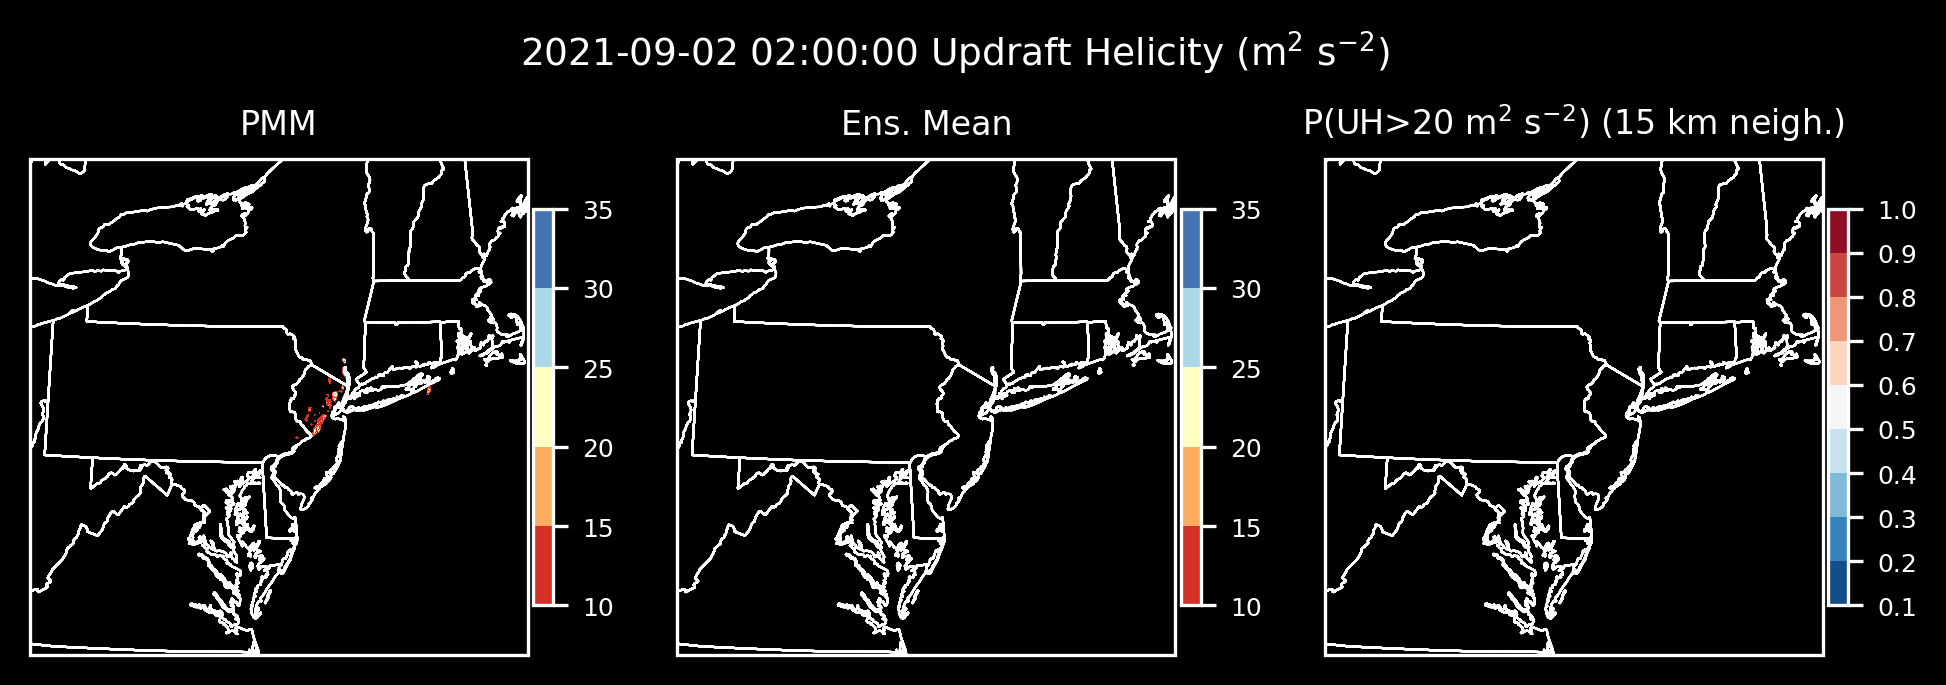

In [12]:
# We want to make an animated gif of the pmm, ensemble mean, and poe
# Make list of titles
titles = ["PMM", "Ens. Mean", "P(UH>20 m$^2$ s$^{-2}$) (15 km neigh.)"]

# Values to plot
values = [pmm_uh, ens_mean_uh, poe_uh]

# Create 1x3 figure
fig, axs = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.17),
    sharex=True,
    sharey=True,
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)


def update(frame):
    for i, ax in enumerate(axs):  # loop through each axis
        # Make plot
        if i < 2:  # if not the last plot
            p = ax.contourf(
                lon,
                lat,
                values[i].isel(time=frame),
                cmap="RdYlBu",
                levels=range(10, 40, 5),
                transform=ccrs.PlateCarree(),
            )
        else:  # if the last plot
            p = ax.contourf(
                lon,
                lat,
                values[i].isel(time=frame),
                cmap="RdBu_r",
                levels=np.arange(0.1, 1.1, 0.1),  # levels from 0.1 to 1 by 0.1
                transform=ccrs.PlateCarree(),
            )
        # Add state boundaries
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

        # Add title
        ax.set_title(titles[i], fontsize=8)

        # Remove previous colorbar if exists
        if hasattr(ax, "colorbar"):
            ax.colorbar.remove()

        # Add colorbar to each plot
        cb = fig.colorbar(p, ax=ax, shrink=0.8, pad=0.01)
        cb.ax.tick_params(labelsize=6)
        ax.colorbar = cb

        # If in first two plots, set colorbar labels to match levels
        if i < 2:
            cb.set_ticks(range(10, 40, 5))  # set ticks
            cb.set_ticklabels(range(10, 40, 5))  # set tick labels

    # Make suptitle containing time value and stating reflectivity
    fig.suptitle(
        str(uh_0102.time.isel(time=frame).values)
        + " Updraft Helicity (m$^2$ s$^{-2}$)",
        fontsize=9,
    )


anim = FuncAnimation(fig, update, frames=13, repeat=True)

anim.save("UH_0to2.gif", writer="Pillow", fps=2)
plt.show()

## Overlays

### Rainfall & Helicity

#### Calculations

In [13]:
# Calculate maximum updraft helicity 01-02 UTC
with ProgressBar():
    uh_max = (
        uh.sel(time=slice("2021-09-02 01:00:00", "2021-09-02 02:00:00"))
        .max(dim="time")  # max over time
        .compute()
    )

# Get probability matched mean of uh_max
pmm_uh_max = pmm(uh_max)  # m^2 s^-2

[                                        ] | 0% Completed | 279.21 us

[########################################] | 100% Completed | 26.39 s


#### Plot it

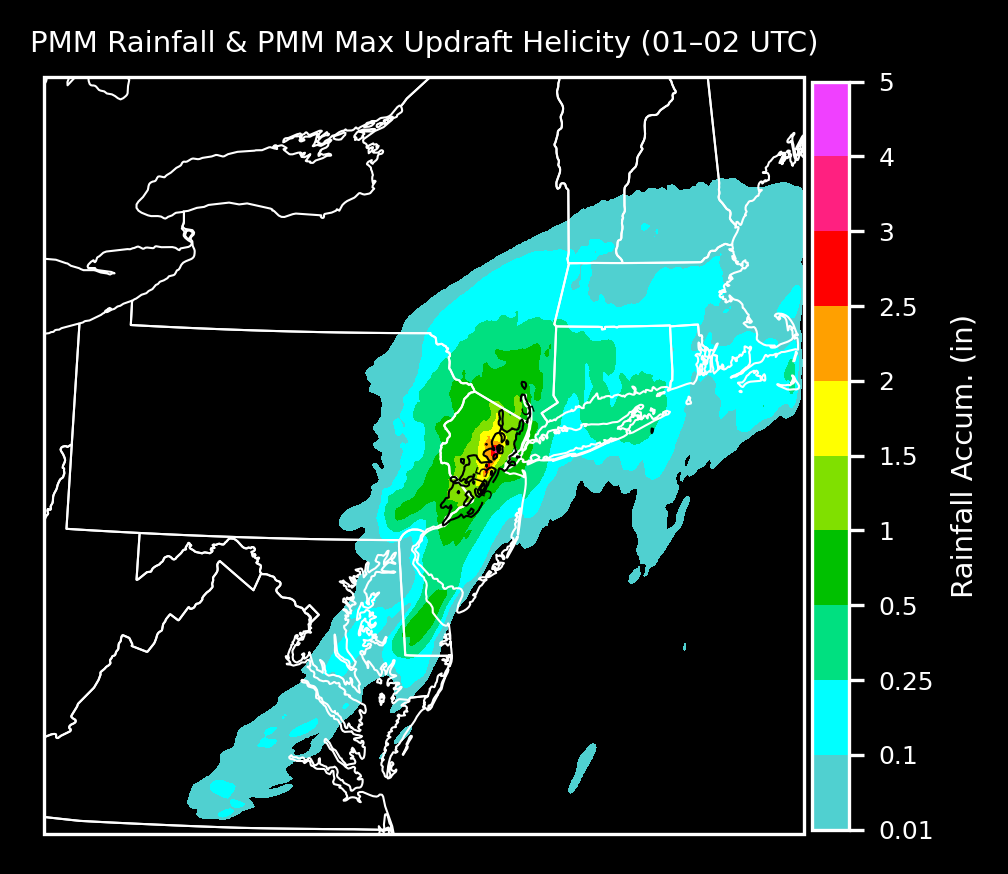

In [14]:
# Make a plot of the pmm_rain with pmm_uh_max contoured over it
fig, ax = plt.subplots(
    1,
    1,
    figsize=(3.2, 3.2),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

# Plot pmm_rain
p = ax.contourf(
    lon,
    lat,
    pmm_rain,
    colors=precip_cmap.colors[1:12],
    levels=[0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5],
    transform=ccrs.PlateCarree(),
)
# Add state boundaries
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

# Add colorbar
cb = fig.colorbar(p, ax=ax, shrink=0.8, pad=0.01)
cb.ax.tick_params(labelsize=6)  # make colorbar labels smaller
cb.set_ticks([0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5])  # set ticks
cb.set_ticklabels([0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5])  # set tick labels
cb.set_label("Rainfall Accum. (in)", fontsize=7)  # set colorbar label

# Contour pmm_uh_max
c = ax.contour(
    lon,
    lat,
    pmm_uh_max,
    colors="black",
    levels=range(5, 40, 10),
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
)

# Add inline contour labels
ax.clabel(c, inline=True, fontsize=4)

# Make title
ax.set_title("PMM Rainfall & PMM Max Updraft Helicity (01–02 UTC)", fontsize=7)

plt.show()